# Imports

In [7]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
import keras.losses
from keras.optimizers import SGD
import pickle

# Functions

In [8]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [9]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img,grayscale):
    x = img_to_array(img)/255.
    if grayscale==True:
        x = rgb2gray(x)   
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [10]:
def rgb2gray(rgb): #https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [11]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size,grayscale):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img,grayscale)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
    
    dataset_np=np.stack(dataset_copy)
    #convert 2D np to pd
    dataset_pd = pd.DataFrame(dataset_np)
    return(dataset_pd)

In [12]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")


    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")
        
    return

In [13]:
def plot_splitted_dataset_distribution(y_train, y_test, y_dev):
    sample_list_names=["Train","Dev","Test"]
    sample_list=[y_train,y_dev,y_test]

    fig = plt.figure(figsize=(15,10))
 
    for i in range(1, 4):
        ax = fig.add_subplot(2,3, i)
        height = Counter(sample_list[i-1])
        bars=('Female','Male')
        pop = plt.bar(bars, height.values(),color=[ 'r','k'])
        plt.xlabel('Gender')
        plt.title('Gender Distribution for '+ sample_list_names[i-1])
    return

In [14]:
def Print_Classification_Results(y_dev,y_pred):
    print(classification_report(y_dev, y_pred))
    acc_score = accuracy_score(y_dev, y_pred)
    print("\nAccuracy Score: ","{:.3%}".format(acc_score))
    conf_matrix = confusion_matrix(y_dev, y_pred)
    labels=['F','M']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return acc_score

In [15]:
def evaluate_and_plot(model, history, X_train, y_train, X_dev, y_dev, y_pred):  
    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    dev_loss, dev_acc = model.evaluate(X_dev, y_dev, verbose=0)
    print('Train: %.3f, Dev: %.3f' % (train_acc, dev_acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # plot loss during training
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='dev')
    ax1.legend()
    ax1.set_ylim([-0.1,1])

    # plot accuracy during training
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='dev')
    ax2.legend()
    ax2.set_ylim([0,1.2])
    plt.show()

    accuracy = Print_Classification_Results(y_dev,y_pred)
    return(accuracy)

In [54]:
def plot_images_true_predicted_smiling(dataset,labels,predictions,images_folder):
    fig = plt.gcf()
    fig.set_size_inches(16,20)
    for i in range(21):
        ax = plt.subplot(5,7,1+i)
        img_id = dataset.index.values[i].astype(int)
        img_id = images_folder + str(img_id)+'.jpg'
        img = load_img(img_id)
        ax.imshow(img, cmap='binary')
        title ="Label=" + str(labels.iloc[i]) + ",Prediction= " +str(predictions[i][0]) 
        ax.set_title(title,fontsize=10)
    plt.show()
    return

# Read Data

In [17]:
dataset = pd.read_csv('../Datasets/celeba/labels.csv', sep = '\t', usecols = [1,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (5000, 2)


,img_name,smiling
0,0.jpg,1
1,1.jpg,1
2,2.jpg,-1
3,3.jpg,-1
4,4.jpg,-1


In [18]:
dataset["smiling"]  = dataset["smiling"].replace(-1,0)
images = dataset.iloc[:,0]
labels = dataset.iloc[:,1]

***Example of a picture in CelebA dataset:***

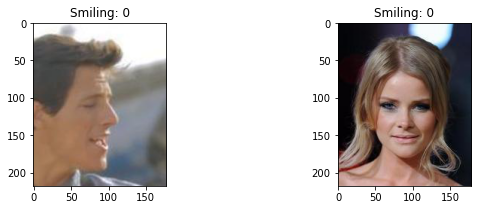

In [19]:
images_folder = '../Datasets/celeba/img/'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

EXAMPLE_PIC = images_folder + '2.jpg'
ax1.set_title("Smiling: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['smiling']))
img = load_img(EXAMPLE_PIC)
ax1.imshow(img)

EXAMPLE_PIC = images_folder + '9.jpg'
ax2.set_title("Smiling: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['smiling']))
img = load_img(EXAMPLE_PIC)
ax2.imshow(img)

**It is of paramount interest to notice that the initial tagging of images for smiling/not smiling has some biases, since some faces, either neutral (with inclination to smiling) or with some orientation, rotation etch have been misclassified from the begginig!!**

## Convert images dataframe to reshaped flattened array images dataframe

Dataset creation with original sized images...
No NaN values in Labels.
No NaN values in Reshaped Images.
Train Set: (3500, 116412) | Dev Set: (750, 116412) | Test Set: (750, 116412)

Dataset creation with reduced sized images...
No NaN values in Labels.
No NaN values in Reshaped Images.
New dataframe: (5000, 30000)
Train Set: (3500, 30000) | Dev Set: (750, 30000) | Test Set: (750, 30000)


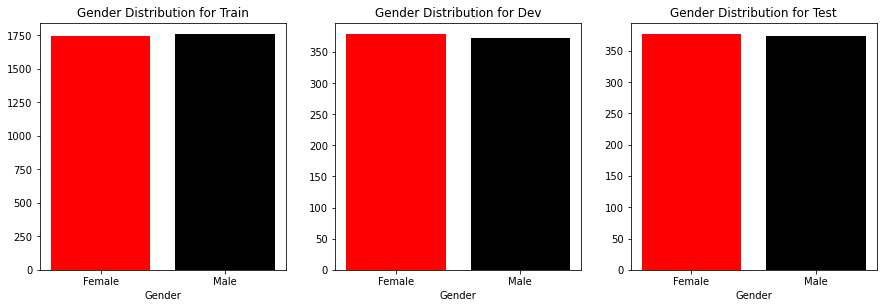

In [20]:
#create dataset with original size of images
print("Dataset creation with original sized images...")
size=(218,178) #100 #64 test them
grayscale=False
reshaped_images=create_flattened_dataset(images,size,grayscale)
check_NaN_values(reshaped_images,labels)
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images, labels)
plot_splitted_dataset_distribution(y_train, y_test, y_dev)

#create dataset with reduced size of images
print("\nDataset creation with reduced sized images...")
size=(100,100) 
grayscale=False
reshaped_images=create_flattened_dataset(images,size,grayscale)
check_NaN_values(reshaped_images,labels)
print("New dataframe:",reshaped_images.shape)
X_train_r, X_test_r, X_dev_r, y_train_r, y_test_r, y_dev_r=train_dev_test_split(reshaped_images, labels)

# Baseline Classification Estimator with Flattened Data

## 1. Linear SVM

### Original image scale = (218,178)

Total runtime:  1390.5937957763672 s
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       372
           1       0.86      0.84      0.85       378

    accuracy                           0.85       750
   macro avg       0.85      0.85      0.85       750
weighted avg       0.85      0.85      0.85       750


Accuracy Score:  84.933%


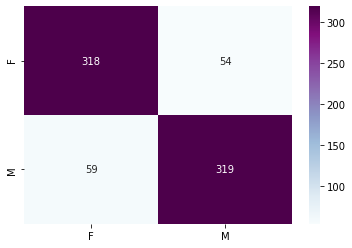

In [82]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train, y_train)
preds_svm_linear = clf_svm_linear.predict(X_dev)
runtime_Linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_Linear_SVM,"s")
acc_Linear_SVM = Print_Classification_Results(y_dev,preds_svm_linear)

### Reduced image scale = (100,100)

Total runtime:  331.01585125923157 s
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       372
           1       0.85      0.83      0.84       378

    accuracy                           0.84       750
   macro avg       0.84      0.84      0.84       750
weighted avg       0.84      0.84      0.84       750


Accuracy Score:  84.000%


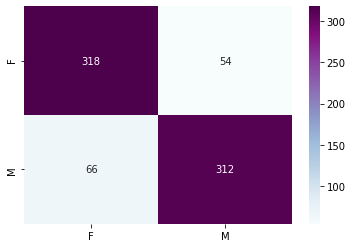

In [93]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train_r, y_train_r)
preds_svm_linear = clf_svm_linear.predict(X_dev_r)
runtime_Linear_SVM_downscaled = time.time()-start_time
print("Total runtime: ",time.time()-start_timeruntime_acc_Linear_SVM_downscaled,"s")
acc_Linear_SVM_downscaled = Print_Classification_Results(y_dev_r,preds_svm_linear)

**We can see that by reducing image size we dont loose important information of images since accuracy is very close to that of original images model, so we keep up with the reduced image size to save computational sources and time.**

## 2. Logistic Regression

**GridSearch to find best fitted solver for reduced scale images:**

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory='tmp',
         steps=[('LR', LogisticRegression(n_jobs=-1, solver='saga'))])
{'LR__solver': 'saga'}
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       372
           1       0.86      0.86      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  86.000%


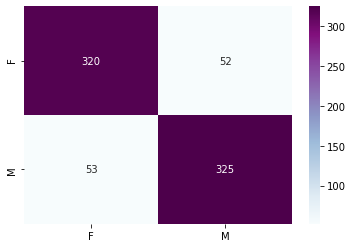

0.86

In [15]:
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
clf = LogisticRegression(n_jobs=-1)
pipe = Pipeline(steps=[('LR', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(LR__solver=solver), cv=5, scoring='accuracy', n_jobs=-1)
estimator.fit(X_train, y_train)
preds = estimator.predict(X_dev)
print(estimator.best_estimator_)
print(estimator.best_params_)
Print_Classification_Results(y_dev,preds)

**Best solver = "Saga"**

### Original image scale = (218,178)

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Total runtime:  502.54681873321533 s
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       372
           1       0.87      0.86      0.87       378

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750


Accuracy Score:  86.533%


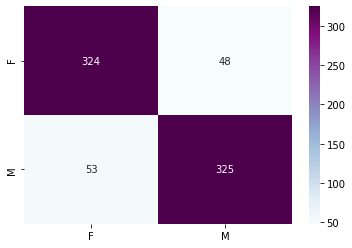

In [74]:
clf_lr = LogisticRegression(solver='saga')
start_time = time.time()
# Train the model using the training sets
clf_lr.fit(X_train, y_train)
preds_lr= clf_lr.predict(X_dev)
runtime_lr = time.time()-start_time
print("Total runtime: ",runtime_acc_lr,"s")
acc_lr = Print_Classification_Results(y_dev,preds_lr)

### Reduced image scale = (100,100)

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Total runtime:  120.45466136932373 s
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       372
           1       0.86      0.86      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  85.867%


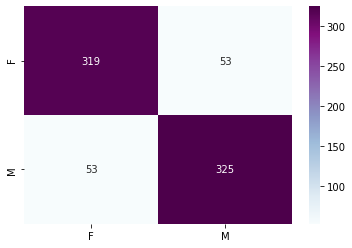

In [18]:
#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and
#‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
clf_lr = LogisticRegression(solver='saga')
start_time = time.time()
# Train the model using the training sets
clf_lr.fit(X_train_r, y_train_r)
preds_lr= clf_lr.predict(X_dev_r)
runtime_lr_downscaled = time.time()-start_time
print("Total runtime: ",runtime_acc_lr_downscaled,"s")
acc_lr_downscaled = Print_Classification_Results(y_dev_r,preds_lr)

We  get the warning that coefficients don't change much between iterations.
One possibility is that we're getting near-perfect separation on the training set, which means there's a hyperplane that separates the two classes. In unpenalized logistic regression, a linearly separable dataset won't have a best fit: the coefficients will blow up to infinity (to push the probabilities to 0 and 1).

## 3.  RBF SVM

### Reduced image scale = (100,100)

*Some experiment results:*

* Score: 0.61 for Parameters: {'C': 0.1, 'gamma': 0.001}
* Score: 0.76 for Parameters: {'C': 1, 'gamma': 0.001}
* Score: 0.77 for Parameters: {'C': 10, 'gamma': 0.001}
* Score: 0.77 for Parameters: {'C': 100, 'gamma': 0.001}
* Score: 0.51 for Parameters: {'C': 1, 'gamma': 0.01}
* Score: 0.52 for Parameters: {'C': 10, 'gamma': 0.01}
* Score: 0.52 for Parameters: {'C': 100, 'gamma': 0.01}

In [13]:
best_score = 0
for gamma in [0.001, 0.01, 0.1]:
    for C in [1, 10, 100]:
        # for each combination of parameters, train a SVC
        svm = SVC(kernel='rbf',gamma=gamma, C=C)
        svm.fit(X_train_r, y_train_r)
        # evaluate the SVC on the dev set
        score = svm.score(X_dev_r, y_dev_r)
        parameters={'C':C,'gamma':gamma}
        print("Score: {:.5f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("\nBest score: {:.5f}".format(best_score))
print("Best parameters: {}".format(best_parameters))
acc_rbf_SVM = best_score

Score: 0.51 for Parameters: {'C': 1, 'gamma': 0.01}
Score: 0.52 for Parameters: {'C': 10, 'gamma': 0.01}
Score: 0.52 for Parameters: {'C': 100, 'gamma': 0.01}


KeyboardInterrupt: 

### Best Model:

Total runtime:  646.8483393192291 s
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       372
           1       0.81      0.71      0.76       378

    accuracy                           0.77       750
   macro avg       0.77      0.77      0.77       750
weighted avg       0.77      0.77      0.77       750


Accuracy Score:  76.933%


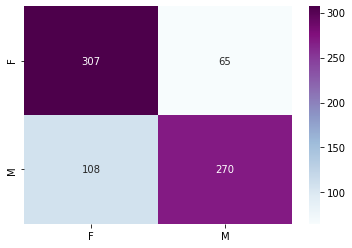

In [80]:
kernel='rbf'
gamma=0.001
C=10
clf_rbf_SVM = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_rbf_SVM.fit(X_train_r, y_train_r)
preds_rbf_SVM = clf_rbf_SVM.predict(X_dev_r)
runtime_rbf_SVM = time.time()-start_time
print("Total runtime: ",runtime_rbf_SVM,"s")
acc_rbf_SVM = Print_Classification_Results(y_dev_r,preds_rbf_SVM)

## 4. kNN Classifier

Total runtime:  180.4803547859192 s
              precision    recall  f1-score   support

           0       0.66      0.43      0.52       372
           1       0.58      0.78      0.67       378

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.60       750
weighted avg       0.62      0.61      0.60       750


Accuracy Score:  60.800%


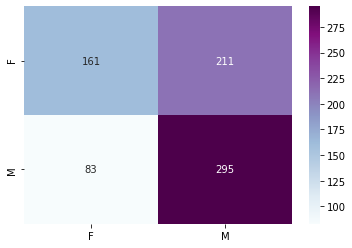

In [76]:
#reduced image scale

myList = list(range(1,40))
neighbors_l = list(filter(lambda x: x % 5 == 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors_l:
    print(k)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_r, y_train_r, scoring='accuracy')
    cv_scores.append(scores.mean())

mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors_l, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# determining best k
optimal_k = neighbors_l[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = neighbors.KNeighborsClassifier(n_neighbors = optimal_k)
start_time = time.time()
knn.fit(X_train_r, y_train_r)
preds_kNN = knn.predict(X_dev_r)
runtime_kNN = time.time()-start_time
print("Total runtime: ",runtime_acc_kNN,"s")
acc_kNN = Print_Classification_Results(y_dev_r,preds_kNN)

## Final Baseline Classifier

In [89]:
data={'kNN (k=30)':[acc_kNN, runtime_kNN],'Linear SVM':[acc_Linear_SVM, runtime_Linear_SVM],
      'Linear SVM-Downscaled':[acc_Linear_SVM_downscaled,runtime_Linear_SVM_downscaled],
      'SVM rbf {}'.format(best_parameters):[best_score,runtime_rbf_SVM],
      'Logistic Regression':[acc_lr,runtime_lr],'Logistic Regression-Downscaled':[acc_lr_downscaled,runtime_lr_downscaled]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score','Total Runtime'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)

,Accuracy Score,Total Runtime
Logistic Regression,0.865333,502.546819
Logistic Regression-Downscaled,0.858670,120.454661
Linear SVM,0.849333,1390.593796
Linear SVM-Downscaled,0.840000,331.015851
"SVM rbf {'C': 10, 'gamma': 0.001}",0.770000,646.848339
kNN (k=30),0.608000,180.480355


# Preproccessing Data

## A. Converting rgb images to gray scale

### A1. Flatten images with original size = (218,178)

In [15]:
size=(218,178)
grayscale=True
reshaped_images_g=create_flattened_dataset(images,size,grayscale)
X_train_g, X_test_g, X_dev_g, y_train_g, y_test_g, y_dev_g=train_dev_test_split(reshaped_images_g, labels)

Train Set: (3500, 38804) | Dev Set: (750, 38804) | Test Set: (750, 38804)


#### Fit Baseline Logistic Regression  on gray scale images

Train Set: (3500, 38804) | Dev Set: (750, 38804) | Test Set: (750, 38804)


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Total runtime:  155.08674573898315 s
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       372
           1       0.86      0.87      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  86.267%


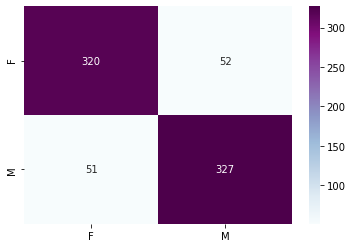

In [91]:
clf_lr_gray =  LogisticRegression(n_jobs=-1,solver='saga')
start_time = time.time()
clf_lr_gray.fit(X_train_g, y_train_g)
preds_lr_gray = clf_lr_gray.predict(X_dev_g)
runtime_lr_gray=time.time()-start_time
print("Total runtime: ",runtime_lr_gray,"s")
acc_gray_lr = Print_Classification_Results(y_dev_g,preds_lr_gray)

### A2. Flatten images with reduced size = (100,100)

In [38]:
size=(100,100)
grayscale=True
reshaped_images_g=create_flattened_dataset(images,size,grayscale)
X_train_r_g, X_test_r_g, X_dev_r_g, y_train_r_g, y_test_r_g, y_dev_r_g=train_dev_test_split(reshaped_images_g, labels)

Train Set: (3500, 10000) | Dev Set: (750, 10000) | Test Set: (750, 10000)


#### Fit Baseline Logistic Regression on gray scale downscaled images

Train Set: (3500, 10000) | Dev Set: (750, 10000) | Test Set: (750, 10000)


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Total runtime:  39.32950568199158 s
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       372
           1       0.87      0.85      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  86.000%


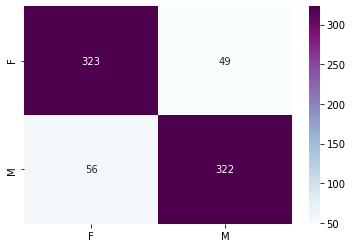

In [92]:
clf_lr_gray_downscaled =  LogisticRegression(n_jobs=-1,solver='saga')
start_time = time.time()
clf_lr_gray_downscaled.fit(X_train_r_g, y_train_r_g)
preds_lr_gray_downscaled = clf_lr_gray_downscaled.predict(X_dev_r_g)
runtime_lr_gray_downscaled = time.time()-start_time
print("Total runtime: ",runtime_lr_gray_downscaled ,"s")
acc_gray_lr_downscaled = Print_Classification_Results(y_dev_r_g,preds_lr_gray_downscaled)

In a nutshell, we can infer that color doesnt afect the detection of smiling or not, **so we will use gray scale images for the next experiments.** 

## B. Curse of Dimensionality

As we saw in Gender classification task A1, feature selection method (variance elaboration) isn;t effective in image processing models so we won't use this method.

#### B1. Feature Extraction - PCA 

We perform **GridSearch with cross-validation** to highlight the best combination of parameters, using reduced size images in gray scale:

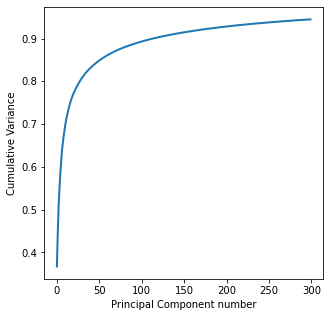

In [33]:
n = 300
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train_r_g)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

**We observe that more than 90% of useful discriminative information can be represented by 120 pca components!!**

##### Find optimal PCA n_component on best baseline model:

In [24]:
clf = LogisticRegression(solver='saga')
best_score = 0
scores_train=[]
scores_dev=[]
n_components = [200,300,400,500,600,1000]
for n in n_components:
    pca = PCA(n_components=n)
    X_train_PCA = pca.fit_transform(X_train_r_g)
    X_dev_PCA = pca.transform(X_dev_r_g)
    clf = LogisticRegression(solver='saga')
    clf.fit(X_train_PCA, y_train_r_g)
    # evaluate the SVC on the dev set
    score_train=clf.score(X_train_PCA, y_train_r_g)
    score_dev=clf.score(X_dev_PCA,y_dev_r_g)
    parameter={'n_components PCA':n}
    print("Score: {:.5f}".format(score_dev), "for Parameter: {}".format(parameter))
    # if we got a better score, store the score and parameters
    scores_train.append(score_train)
    scores_dev.append(score_dev)
    if score_dev > best_score:
        best_score = score_dev
        best_parameter = {'n_components PCA':n}

print("\nBest score: {:.3%}".format(best_score))
print("Best parameter: {}".format(best_parameter))

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score: 0.83867 for Parameter: {'n_components PCA': 200}


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score: 0.85067 for Parameter: {'n_components PCA': 300}


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score: 0.85067 for Parameter: {'n_components PCA': 400}


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score: 0.86533 for Parameter: {'n_components PCA': 500}


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score: 0.86533 for Parameter: {'n_components PCA': 600}
Score: 0.85867 for Parameter: {'n_components PCA': 1000}

Best score: 86.533%
Best parameter: {'n_components PCA': 500}


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


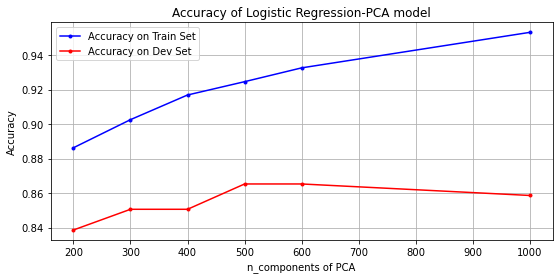

In [30]:
plt.figure(figsize=(9,4))
plt.title('Accuracy of Logistic Regression-PCA model')

plt.plot(n_components,scores_train,'r.-', c ='b',label='Accuracy on Train Set')
plt.plot(n_components,scores_dev, 'r.-', c='r',label='Accuracy on Dev Set')
plt.ylabel('Accuracy')
plt.xlabel('n_components of PCA')
plt.grid()
plt.legend()
plt.show()

**Our model performed better for n_components = 500, since this was the appropriate number of features that the model do not overfit on train data and Generalisation Error is the kind of low.**

##### Fit LR model to the best n_component PCA = 500:

Total runtime:  2.0874197483062744 s
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       372
           1       0.88      0.84      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  86.133%


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


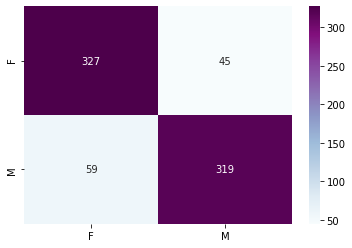

In [42]:
n = 500
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train_r_g)
X_dev_PCA = pca.transform(X_dev_r_g)

clf_lr_PCA = LogisticRegression(solver='saga')
start_time = time.time()
# Train the model using the training sets
clf_lr_PCA.fit(X_train_PCA, y_train_r_g)
preds_lr_PCA= clf_lr_PCA.predict(X_dev_PCA)
runtime_lr_PCA_downscaled_gray = time.time()-start_time
print("Total runtime: ",runtime_lr_PCA_downscaled_gray,"s")
acc_lr_PCA_downscaled_gray = Print_Classification_Results(y_dev_r_g,preds_lr_PCA)

### Compare Baseline model with Preprocessed

In [96]:
data={'Logistic Regression-Downscaled-Gray-PCA(n=500)':[acc_lr_PCA_downscaled_gray, runtime_lr_PCA_downscaled_gray],
      'Logistic Regression-Gray':[acc_gray_lr,runtime_lr],
      'Logistic Regression-Downscaled-Gray':[acc_gray_lr_downscaled,runtime_lr],
      'Logistic Regression':[acc_lr,runtime_lr],
      'Logistic Regression-Downscaled':[acc_lr_downscaled,runtime_lr_downscaled]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score','Total Runtime'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)

,Accuracy Score,Total Runtime
Logistic Regression,0.865333,502.546819
Logistic Regression-Downscaled-Gray-PCA(n=500),0.864000,2.189146
Logistic Regression-Gray,0.862667,502.546819
Logistic Regression-Downscaled-Gray,0.860000,502.546819
Logistic Regression-Downscaled,0.858670,120.454661


C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


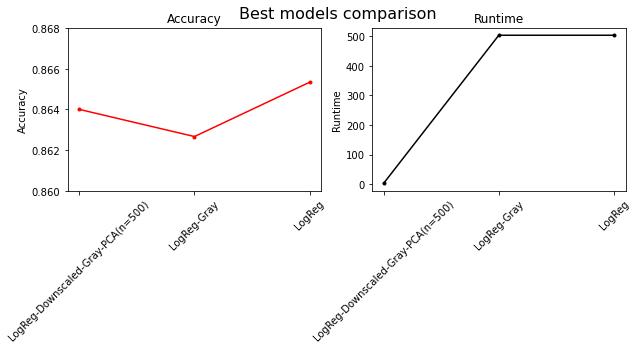

In [139]:
model_list_names=["LogReg-Downscaled-Gray-PCA(n=500)","LogReg-Gray","LogReg"]
accuracy_list=[acc_lr_PCA_downscaled_gray,acc_gray_lr,acc_lr]
runtime_list=[runtime_lr_PCA_downscaled_gray,runtime_lr,runtime_lr]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Best models comparison', fontsize=16)

ax1.set_title('Accuracy')
ax1.plot(model_list_names,accuracy_list, 'r.-')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.86,0.868])
ax1.set_xticklabels(labels=model_list_names,rotation=45)

ax2.set_title('Runtime')
ax2.plot(model_list_names,runtime_list, 'k.-')
ax2.set_ylabel('Runtime')
ax2.set_xticklabels(labels=model_list_names,rotation=45)

plt.show()

**Plotting the accuracies and runtime of the proposed models, we infer that the model "LogReg-Downscaled-Gray-PCA(n=500)" is the most well suited, since its accuracy differ only in thousandths (3rd decimal place) from the model "LogReg", while its runtime is incomparable to this of "LogReg" model's, with values 2.18 and 502.54, accordingly.**


# CNN

The term deep neural nets refers to any neural network with several hidden layers. Convolutional neural nets are a specific type of deep neural net which are especially useful for image recognition. Specifically, convolutional neural nets use convolutional and pooling layers, which reflect the translation-invariant nature of most images. For τηισ problem, CNNs would work better than generic DNNs since they implicitly capture the structure of images.

We use directly CNN, without examining DNN since CNN is a special Deep Learning technique which has proven to be greatly effective when data can be expressed in the form of multidimensional inputs, like our dataset which constistd of images. To put it forth simply, this type of neural network learns to identify distinctive patterns which could potentially shift and distort around.

https://medium.com/@reubensinha7/smile-detection-a-hello-world-for-computer-vision-1b70dc65b9dc

In [57]:
def cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, Xtrain, ytrain, Xdev, ydev, dim, checkpointer, checkpoint_filepath):
    print('Build model...')
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',kernel_initializer=TruncatedNormal(stddev=0.1), input_shape=(IMG_HEIGHT, IMG_WIDTH,dim)))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='Same',kernel_initializer=TruncatedNormal(stddev=0.1)))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     #model.add(Dropout(0.2))
#     model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='Same',kernel_initializer=TruncatedNormal(stddev=0.1)))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    

    model.add(Flatten())
#    model.add(Dense(1024, activation='relu'))
#    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu',kernel_initializer=TruncatedNormal(stddev=0.1)))
    model.add(Dropout(0.3)) 
    model.add(Dense(1, activation='sigmoid',kernel_initializer=TruncatedNormal(stddev=0.1)))

    # Compile the network :
    model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    history=model.fit(Xtrain, ytrain, validation_data=(Xdev, ydev), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,callbacks=[checkpointer])
    model.load_weights(checkpoint_filepath)
    y_pred = model.predict_classes(Xdev)
    
    return(model, history, y_pred)

## Convert images dataframe to multidimensional array images dataframe

In [51]:
#create dataset with original size of images
X_train_d = X_train.to_numpy()
X_dev_d = X_dev.to_numpy()
X_test_d = X_test.to_numpy()
print('Before: ', X_train_d.shape, X_dev_d.shape)
X_train_d=X_train_d.reshape((X_train_d.shape[0], 218, 178, 3))
X_dev_d=X_dev_d.reshape((X_dev_d.shape[0], 218, 178, 3))
X_test_d=X_test_d.reshape((X_test_d.shape[0], 218, 178, 3))
print('After: ', X_train_d.shape, X_dev_d.shape)

#create dataset with reduced size of images
X_train_r_d = X_train_r.to_numpy()
X_dev_r_d = X_dev_r.to_numpy()
X_test_r_d = X_test_r.to_numpy()
print('Before: ', X_train_r_d.shape, X_dev_r_d.shape)
X_train_r_d=X_train_r_d.reshape((X_train_r_d.shape[0], 100,100, 3))
X_dev_r_d=X_dev_r_d.reshape((X_dev_r_d.shape[0], 100,100, 3))
X_test_r_d=X_test_r_d.reshape((X_test_r_d.shape[0], 100,100, 3))
print('After: ', X_train_r_d.shape, X_dev_r_d.shape)

#create dataset with reduced size of images in gray scale
X_train_r_g_d = X_train_r_g.to_numpy()
X_dev_r_g_d = X_dev_r_g.to_numpy()
X_test_r_g_d = X_test_r_g.to_numpy()
print('Before: ', X_train_r_g_d.shape, X_dev_r_g_d.shape)
X_train_r_g_d=X_train_r_g_d.reshape((X_train_r_g_d.shape[0], 100,100, 1))
X_dev_r_g_d=X_dev_r_g_d.reshape((X_dev_r_g_d.shape[0], 100,100, 1))
X_test_r_g_d=X_test_r_g_d.reshape((X_test_r_g_d.shape[0], 100,100, 1))
print('After: ', X_train_r_g_d.shape, X_dev_r_g_d.shape)

Before:  (3500, 116412) (750, 116412)
After:  (3500, 218, 178, 3) (750, 218, 178, 3)
Before:  (3500, 30000) (750, 30000)
After:  (3500, 100, 100, 3) (750, 100, 100, 3)
Before:  (3500, 10000) (750, 10000)
After:  (3500, 100, 100, 1) (750, 100, 100, 1)


## A. Fit Rescaled Image Data with shape = (100,100,3)

In [59]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 100
EPOCHS = 20
dim = 3
opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

Build model...
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_173 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_171 (MaxPoolin (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_118 (Dropout)        (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 25

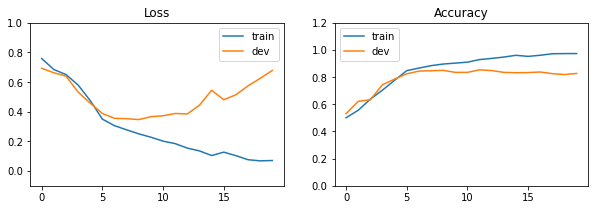

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       372
           1       0.85      0.80      0.82       378

    accuracy                           0.83       750
   macro avg       0.83      0.83      0.83       750
weighted avg       0.83      0.83      0.83       750


Accuracy Score:  82.667%


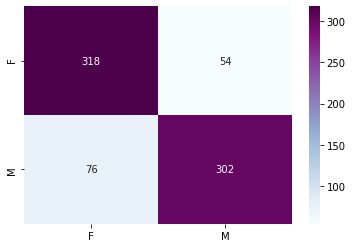

In [147]:
opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

start_time = time.time()
model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, dim)
runtime = time.time()-start_time
print("Total runtime: ",runtime,"s")
print(model.metrics_names)
print(model.evaluate(X_train_r_d, y_train_r))
accuracy = evaluate_and_plot(model, history, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, y_pred)

* **We observe that as epochs increase, model overfit on training data, so we stop training at a smaller number of epochs.**
* **Optimizers: SGD couldn't converge, RMSprop(with various parameters the learning procedure ameliorates but never reaches Adam's) slower than adam but decent.**



**Adam optimizer comes to fit better and faster than the others!**

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/:
https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c:
* Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
* Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
* Adam is relatively easy to configure where the default configuration parameters do well on most problems.


### A1. Architecture: Dropout layers between convolutional layers and two dense layers with dropout between 1st and second

Build model...
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_282 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_283 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_284 (Conv2D)          (None, 25

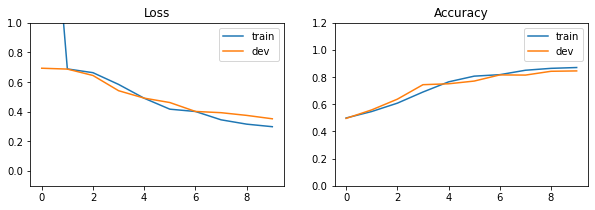

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       372
           1       0.87      0.81      0.84       378

    accuracy                           0.85       750
   macro avg       0.85      0.85      0.85       750
weighted avg       0.85      0.85      0.85       750


Accuracy Score:  84.533%


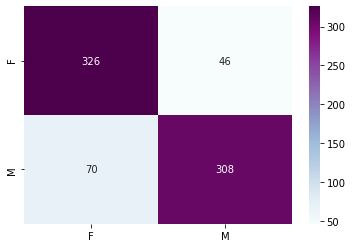

In [91]:
#Architecture: Dropouts between convolutional layers and two dense layres with dropout between
#Conv(x32),Pool,Dropout-Conv(x64),Pool,Dropout-Conv(x128),Pool-Dense(1024),Dropout-Dense(128)

BATCH_SIZE = 100
EPOCHS = 10
dim = 3
opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

checkpoint_filepath = 'weights.best.modelA1.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)

model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, dim, checkpointer, checkpoint_filepath)
model.save('best.modelA1.h5')
print(model.metrics_names)
print(model.evaluate(X_train_r_d, y_train_r))
accuracy = evaluate_and_plot(model, history, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, y_pred)

### A2. Architecture: remove dropout layers between convolutional layers and the 1st dense layer,  add dropout between dense layer and output layer

Build model...
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_338 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_339 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_340 (Conv2D)          (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 18

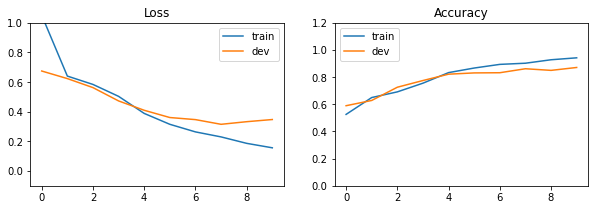

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       372
           1       0.86      0.87      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  86.133%


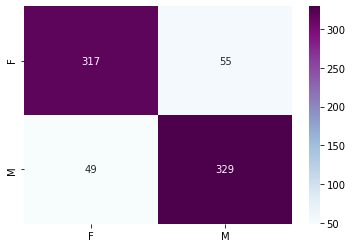

In [139]:
#Architecture: remove dropouts between convolutional layers and 1st dense layer, Add dropout between dense layer and output layer
#Conv(x32),Pool-Conv(x64),Pool-Conv(x128),Pool-Dense(128),Dropout

BATCH_SIZE = 100
EPOCHS = 10
dim = 3
opt = keras.optimizers.Adam() 

checkpoint_filepath = 'weights.best.modelA2.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)
model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, dim, checkpointer, checkpoint_filepath)
model.save('best.modelA2.h5')
print(model.metrics_names)
print(model.evaluate(X_train_r_d, y_train_r))
accuracy = evaluate_and_plot(model, history, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, y_pred)

### A3. Architecture: One convolutional layer and the one dense layer with dropout between dense layer and output layer

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10240128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 10,241,153
Trainable params: 10,241,153
Non-trainable params: 0
___________________________

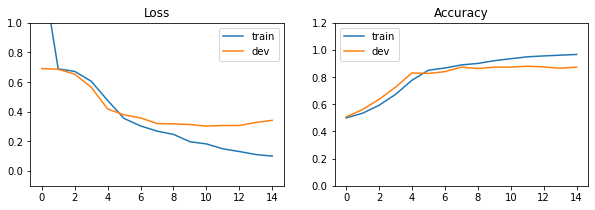

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       372
           1       0.87      0.88      0.87       378

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750


Accuracy Score:  87.333%


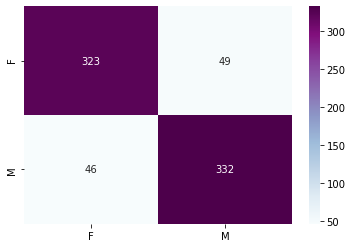

In [22]:
#Architecture: remove dropouts between convolutional layers and 1st dense layer, Add dropout between dense layer and output layer
#Conv(x32),Pool-Dense(128),Dropout

BATCH_SIZE = 100
EPOCHS = 15
dim = 3
opt = keras.optimizers.Adam() 

checkpoint_filepath = 'weights.best.modelA3.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)
model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, dim, checkpointer, checkpoint_filepath)
model.save('best.modelA3.h5')
print(model.metrics_names)
print(model.evaluate(X_train_r_d, y_train_r))
acc_A3 = evaluate_and_plot(model, history, X_train_r_d, y_train_r, X_dev_r_d, y_dev_r, y_pred)

## B. Fit Rescaled Gray Image Data with shape = (100,100,1)

### B1. Architecture: Dropout layers between 3 convolutional layers and two dense layers with dropout between 1st and second

Build model...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_240 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 25

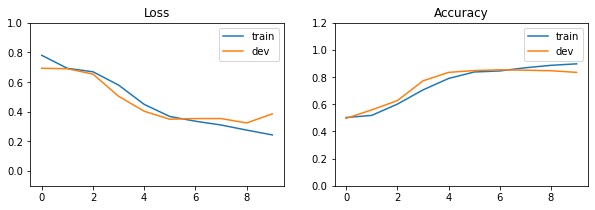

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       372
           1       0.95      0.71      0.81       378

    accuracy                           0.83       750
   macro avg       0.86      0.84      0.83       750
weighted avg       0.86      0.83      0.83       750


Accuracy Score:  83.467%


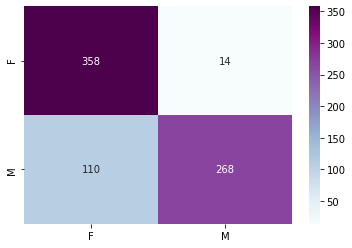

In [67]:
#Conv(x32),Pool,Dropout-Conv(x64),Pool,Dropout-Conv(x128),Pool-Dense(1024),Dropout-Dense(128)

BATCH_SIZE = 100
EPOCHS = 10
dim = 1

checkpoint_filepath = 'weights.best.modelB1.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)
#Architecture: remove dropouts between convolutional layers and 1st dense layer, Add dropout between dense layer and output layer
opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, dim, checkpointer, checkpoint_filepath)
print(model.metrics_names)
print(model.evaluate(X_train_r_g_d, y_train_r_g))
accuracy = evaluate_and_plot(model, history, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, y_pred)

### B2. Architecture: remove dropout layers between the 3 convolutional layers and the 1st dense layer, add dropout between dense layer and output layer

Build model...
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_331 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_332 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_333 (Conv2D)          (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 12

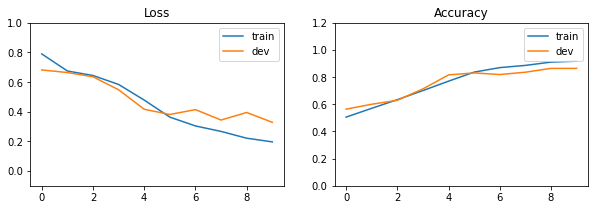

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       372
           1       0.88      0.85      0.86       378

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750


Accuracy Score:  86.400%


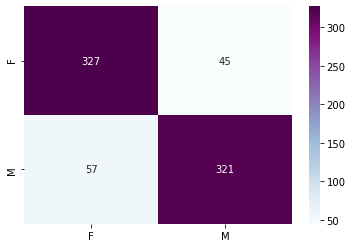

In [133]:
#Conv(x32),Pool-Conv(x64),Pool-Conv(x128),Pool-Dense(128),Dropout

BATCH_SIZE = 100
EPOCHS = 10
dim = 1

#create checkpoint to store the best fitted weights
checkpoint_filepath = 'weights.best.modelB2.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)

opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

#Architecture: remove dropouts between convolutional layers and 1st dense layer, Add dropout between dense layer and output layer
opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, dim,checkpointer,checkpoint_filepath)
print(model.metrics_names)
print(model.evaluate(X_train_r_g_d, y_train_r_g))
accuracy = evaluate_and_plot(model, history, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, y_pred)

model.save('best.modelB2.h5')
#model.save_weights('weights.best.models.hdf5')

### B3. Architecture: Only the first convolutional layer and the one dense layer with dropout between dense layer and output layer

Build model...
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_352 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_130 (Dense)            (None, 128)               10240128  
_________________________________________________________________
dropout_69 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 129       
Total params: 10,240,577
Trainable params: 10,240,577
Non-trainable params: 0
__________________________

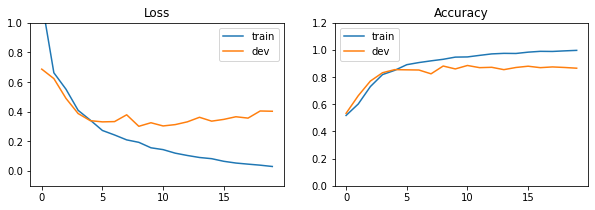

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       372
           1       0.88      0.89      0.88       378

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750


Accuracy Score:  88.133%


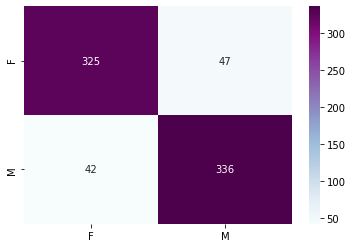

In [155]:
#Conv(x32),Pool-Dense(128),Dropout

BATCH_SIZE = 100
EPOCHS = 20
dim = 1

#create checkpoint to store the best fitted weights
checkpoint_filepath = 'weights.best.modelB3.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, save_best_only=True)

#Architecture: remove dropouts between convolutional layers and 1st dense layer, Add dropout between dense layer and output layer
opt = keras.optimizers.Adam() #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

start_time = time.time()
model, history, y_pred = cnn(IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS, opt, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, dim,checkpointer,checkpoint_filepath)
runtime_B3 = time.time()-start_time
print(model.metrics_names)
print(model.evaluate(X_train_r_g_d, y_train_r_g))
acc_B3 = evaluate_and_plot(model, history, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, y_pred)

model.save('best.modelB3.h5')

**We can infer just like in case A that the architecture (A3, B3) with one convolutional layer and one hidden dense layer with dropout before output layer leads to a more generalized model than the other architectures, faster and with greatest accuracy where training data do not overfit. This maybe happens because out data consist of portraits that do not need really any preprocessing to be transformed into focused clear faces. Hence feature extraction happens more easily through the first 32 filters and more layers are just redundant.**

## C. Fit Augmented Image Data

In [22]:
#create a image generator for augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

### C1. Fit reduced scaled augmented data to the best studied architecture till now

In [159]:
def cnn_augm(IMG_HEIGHT, IMG_WIDTH, opt ,dim):
    print('Build model...')
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH,dim)))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='Same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='Same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

#    model.add(GlobalAveragePooling2D())
#     #model.add(Dense(1024, activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the network :
    model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
    model.summary()
    return(model)

#### Apply Data Augmentation to train data before being fed to the cnn into batches

In [158]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 100
EPOCHS = 20
dim = 3
opt = keras.optimizers.Adam()  #Adagrad() #SGD(lr=0.01, momentum=0.9, decay=0.01)

#create checkpoint to store the best fitted weights
checkpointer = ModelCheckpoint(filepath='weights.best.augm_model.hdf5', 
                               verbose=1, save_best_only=True)

#flow training images in batches using datagen generator which transforms 
#each image in the batch by a series of random translations, rotations,etc.
datagen.fit(X_train_r_d)

train_generator = datagen.flow(
X_train_r_d, y_train_r,
batch_size=BATCH_SIZE, 
)

#create the architecture of model
model = cnn_augm(IMG_HEIGHT, IMG_WIDTH, opt, dim)

#fit augmented training data in batches 
history = model.fit_generator(train_generator
                     , validation_data = (X_dev_r_d, y_dev_r)
                      , steps_per_epoch= X_train_r_d.shape[0]/BATCH_SIZE #this will use all of the data points, one batch size worth at a time.
                      , epochs= EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Build model...
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_354 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_63 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_134 (Dense)            (None, 128)               10240128  
_________________________________________________________________
dropout_71 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 129       
Total params: 10,241,153
Trainable params: 10,241,153
Non-trainable params: 0
__________________________

KeyboardInterrupt: 

['loss', 'accuracy']
Train: 0.690, Dev: 0.644


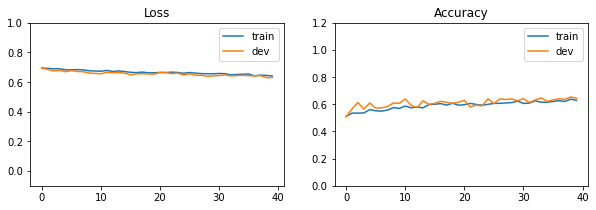

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       372
           1       0.64      0.66      0.65       378

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750


Accuracy Score:  64.400%


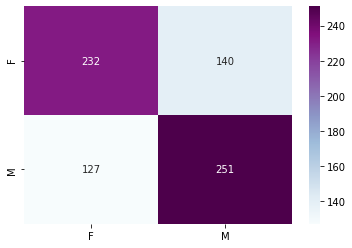

In [34]:
# evaluate the model
y_pred = model.predict(X_dev_r_g_d)
y_pred = [0 if x<0.5 else 1 for x in y_pred]
accuracy = evaluate_and_plot(model, history, X_train_r_g_d, y_train_r_g, X_dev_r_g_d, y_dev_r_g, y_pred)

### C2. Fit reduced scaled augmented data to a custom network consisted of the pretrained Inceptionv3 and 2 dense layers

In [59]:
#load pretrained model on Imagenet
pretrained_model = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(pretrained_model.layers))
#pretrained_model.summary()

number of layers: 311


In [60]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 100
EPOCHS = 10

#Adding custom Layers
pretrained_output_layer = pretrained_model.output
x = GlobalAveragePooling2D()(pretrained_output_layer)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=pretrained_model.input, outputs=output)

# Lock initial layers to do not be trained
for layer in model.layers[:311]:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam' 
              #optimizer='adam' missperform -> overfitting
              #optimizer=SGD(lr=0.0001, momentum=0.9) ->very slow convergence
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

#create checkpoint to store the best fitted weights
checkpointer = ModelCheckpoint(filepath='weights.best.augm_models.hdf5', 
                               verbose=1, save_best_only=True)
datagen.fit(X_train_r_d)

train_generator = datagen.flow(
X_train_r_d, y_train_r,
batch_size=BATCH_SIZE, 
)

#fit train augmented data in batches 
history = model.fit_generator(train_generator
                     , validation_data = (X_dev_r_d, y_dev_r)
                      , steps_per_epoch= X_train_r_d.shape[0]/BATCH_SIZE #this will use all of the data points, one batch size worth at a time.
                      , epochs= EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/10
35/35 [==============================] - 46s 1s/step - loss: 0.7447 - accuracy: 0.5100 - val_loss: 0.9193 - val_accuracy: 0.4960

Epoch 00001: val_loss improved from inf to 0.91927, saving model to weights.best.augm_models.hdf5
Epoch 2/10
35/35 [==============================] - 43s 1s/step - loss: 0.7175 - accuracy: 0.5214 - val_loss: 0.6952 - val_accuracy: 0.5147

Epoch 00002: val_loss improved from 0.91927 to 0.69520, saving model to weights.best.augm_models.hdf5
Epoch 3/10
35/35 [==============================] - 42s 1s/step - loss: 0.7132 - accuracy: 0.5206 - val_loss: 0.7563 - val_accuracy: 0.4973

Epoch 00003: val_loss did not improve from 0.69520
Epoch 4/10
35/35 [==============================] - 41s 1s/step - loss: 0.6956 - accuracy: 0.5274 - val_loss: 0.6878 - val_accuracy: 0.5467

Epoch 00004: val_loss improved from 0.69520 to 0.68784, saving model to weights.best.augm_models.hdf5
Epoch 5/10
35/35 [==============================] - 43s 1s/step - loss: 0.6925 - ac

 **Results show that data augmentation methods DO NOT result in an improvement to the model performance. Modern deep learning algorithms, such as the convolutional neural network, or CNN, can learn features that are invariant to their location in the image. Nevertheless, augmentation can further aid in this transform invariant approach to learning and can aid the model in learning features that are also invariant to transforms such as left-to-right to top-to-bottom ordering, light levels in photographs, and more. However in our occasion that our NN try to find patterns between features that do not cover the whole image but a small part of it, data augmentation only increases the volume of input data in our model, without contributing to their variability.**

# Best performing model

## Compare best fitted models on Dev Set

|                                                                                          |   Accuracy Score |
|:-----------------------------------------------------------------------------------------|-----------------:|
| Logistic Regression-Downscaled-Gray-PCA(n=500)                                           |          0.864   |
| CDNN (Conv(x32),Pool-Dense(128),Dropout)-RGB or A3 model                                 |          0.87333 |
| CDNN (Conv(x32),Pool-Conv(x64),Pool-Conv(x128),Pool-Dense(128),Dropout)-Gray or B3 model |          0.88133 |


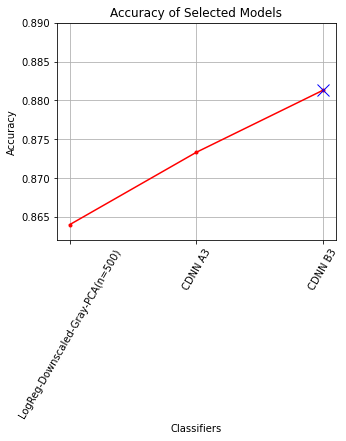

In [49]:
acc_lr_PCA_downscaled_gray=0.86400
acc_A3= 0.87333
acc_B3=0.88133
data={'Logistic Regression-Downscaled-Gray-PCA(n=500)':[acc_lr_PCA_downscaled_gray],
      'CDNN (Conv(x32),Pool-Dense(128),Dropout)-RGB or A3 model':[acc_A3],
      'CDNN (Conv(x32),Pool-Conv(x64),Pool-Conv(x128),Pool-Dense(128),Dropout)-Gray or B3 model':[acc_B3]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)
print(df.to_markdown()) 

accuracies = [acc_lr_PCA_downscaled_gray,acc_A3,acc_B3]
acc_list=['LogReg-Downscaled-Gray-PCA(n=500)','CDNN A3','CDNN B3']
plt.figure(figsize=(5,4))
plt.title('Accuracy of Selected Models')
plt.plot(acc_list,accuracies, 'r.-')

#spot maximum accuracy
acc_max = np.array(accuracies).max()
index=np.where(accuracies==acc_max)
index = index[0][0]
plt.plot(acc_list[index],acc_max,'x',color='b',markersize=12)


plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.xticks(rotation=60)
plt.ylim([0.862,0.89])
plt.show()

## Accuracy of Best Model on Dev Set: 

Best model's architecture: Conv(x32) + Pool, Dense(128) + Dropout(0.3), Dense(1) on reduced scale data (100X100) in 1D dimension (gray) . Check B3 subsection

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       372
           1       0.88      0.89      0.88       378

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750


Accuracy Score:  88.133%


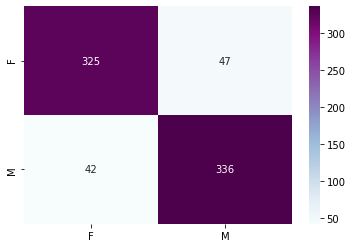

In [52]:
model=load_model('best.modelB3.h5')
model.load_weights('weights.best.modelB3.hdf5')
y_pred = model.predict_classes(X_dev_r_g_d)
accuracy_B3_dev = Print_Classification_Results(y_dev_r_g,y_pred)

## Accuracy of Best Model on Test Set: 


              precision    recall  f1-score   support

           0       0.88      0.90      0.89       374
           1       0.90      0.88      0.89       376

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89.333%


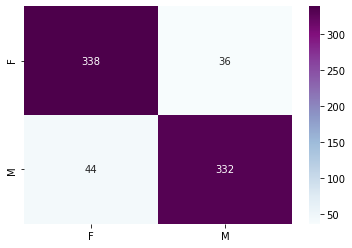

In [66]:
model=load_model('best.modelB3.h5')
model.load_weights('weights.best.modelB3.hdf5')
y_pred = model.predict_classes(X_test_r_g_d)
accuracy_B3_test = Print_Classification_Results(y_test_r_g,y_pred)

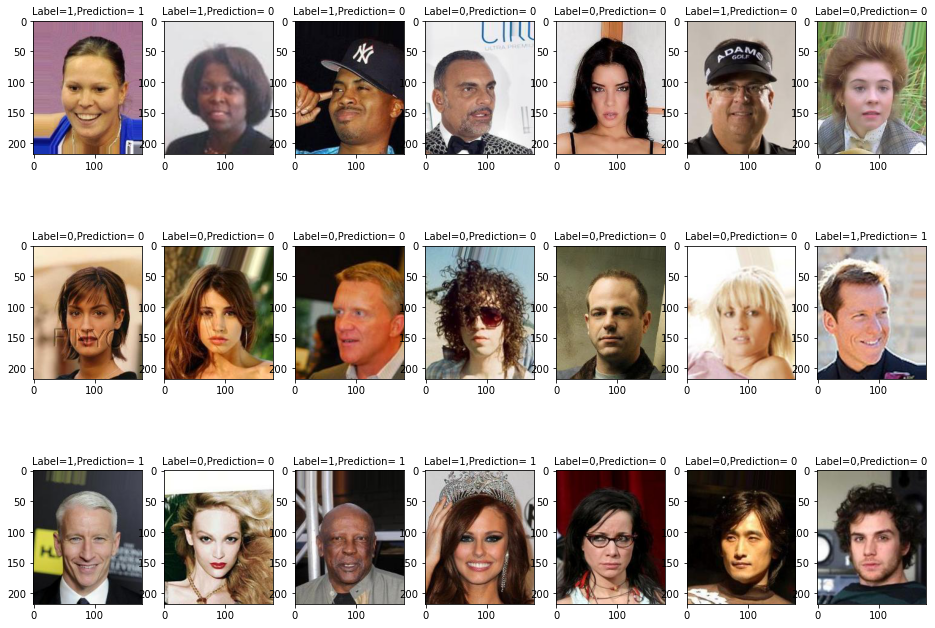

In [55]:
plot_images_true_predicted_smiling(X_test_r_g,y_test_r_g,y_pred,images_folder)

## Compare Baseline and Best model's Accurracy on Test Set

### Baseline model vs Best model on Test Set

* *Estimator*: Logistic Regression **vs** CNN with 1 convolution layer and 1 dense
* *Training Data*: Flattened images of size=(218,178) in RGB scale **vs** Reduced images of size=(100,100) in Gray scale , which means that our model reaches better accuracy **with much less amount of features in much quicker runtime**.


Accuracy Score of Test Set for Baseline Model:  87.600%

Accuracy Score of Test Set for Best Model:  89.333%


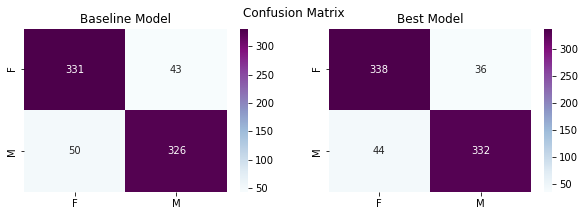

In [79]:
#Baseline model
preds_lr= clf_lr.predict(X_test)
acc_lr = accuracy_score(y_test, preds_lr)
print("\nAccuracy Score of Test Set for Baseline Model: ","{:.3%}".format(acc_lr))
conf_matrix1 = confusion_matrix(y_test, preds_lr)

#Best model
y_pred = model.predict_classes(X_test_r_g_d)
accuracy_B3 = accuracy_score(y_test_r_g,y_pred)
print("\nAccuracy Score of Test Set for Best Model: ","{:.3%}".format(accuracy_B3))
conf_matrix2 = confusion_matrix(y_test_r_g, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Confusion Matrix', fontsize=12)
labels=['F','M']

ax1.set_title('Baseline Model')
sns.heatmap(conf_matrix1, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax1)

ax2.set_title('Best Model')
sns.heatmap(conf_matrix2, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax2)
plt.show()

#### Compare runtimes

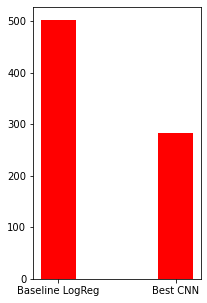

In [78]:
# runtime_lr=502.546819
# runtime_B3=283.3046486377716

models = ["Baseline LogReg","Best CNN"]
runtimes = [runtime_lr, runtime_B3]
fig = plt.figure(figsize=(3,5))
pop = plt.bar(models, runtimes,color=[ 'r'],width=0.3)

### Plot Baseline Logistic Regression and Best model accuracy on Train, Dev and Test Data and compare runtimes

In [81]:
preds = clf_lr.predict(X_train)
acc_lr_train = accuracy_score(y_train, preds)
preds = clf_lr.predict(X_dev)
acc_lr_dev = accuracy_score(y_dev, preds)
preds = clf_lr.predict(X_test)
acc_lr_test = accuracy_score(y_test, preds)

model=load_model('best.modelB3.h5')
model.load_weights('weights.best.modelB3.hdf5')
preds = model.predict_classes(X_train_r_g_d)
acc_B3_train= accuracy_score(y_train_r_g,preds)
preds = model.predict_classes(X_dev_r_g_d)
acc_B3_dev = accuracy_score(y_dev_r_g,preds)
preds = model.predict_classes(X_test_r_g_d)
acc_B3_test= accuracy_score(y_test_r_g,preds)

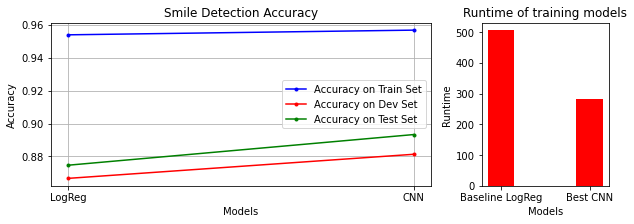

In [104]:
models=["LogReg","CNN"]
scores_train = [acc_lr_train, acc_B3_train]
scores_dev = [acc_lr_dev, acc_B3_dev]
scores_test = [acc_lr_test, acc_B3_test]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3),gridspec_kw={'width_ratios': [3, 1]})
ax1.set_title('Smile Detection Accuracy')
ax1.plot(models,scores_train,'r.-', c ='b',label='Accuracy on Train Set')
ax1.plot(models,scores_dev, 'r.-', c='r',label='Accuracy on Dev Set')
ax1.plot(models,scores_test, 'r.-', c='g',label='Accuracy on Test Set')
ax1.legend()
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Models')
ax1.grid()

# runtime_lr=502.546819
# runtime_B3=283.3046486377716
models = ["Baseline LogReg","Best CNN"]
runtimes = [runtime_lr, runtime_B3]
ax2.bar(models, runtimes,color=[ 'r'],width=0.3)
ax2.set_title('Runtime of training models')
ax2.set_ylabel('Runtime')
ax2.set_xlabel('Models')


plt.show()